In [1]:
#import libraries
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import glob
from sklearn.metrics import confusion_matrix
import os
import sys
import warnings
import IPython.display as ipd
import seaborn as sns
import glob
import pickle
import json

if not sys.warnoptions :
    warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", category  = DeprecationWarning)

We are taking 4 datasets, which are SAVEE dataset, RAVDESS dataset, TESS dataset and CREMA - D dataset, these all are in kaggle. 

In [2]:
TESS = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
RAV = "../input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
SAVEE = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"
CREMA = "../input/cremad/AudioWAV/"

# SAVEE DATASET

In [3]:
dir_list = os.listdir(SAVEE)
dir_list[0:5]

#for i in dir_list:
#    print(i[-8 : -6])

['DC_su08.wav', 'KL_d11.wav', 'KL_n27.wav', 'JE_d11.wav', 'KL_a06.wav']

SAVEE datasets
emotions are as follows
* a : anger
* d : disgust
* f : fear
* h : happiness
* sa: sadness
* su: surprise
* n : neutral

Load the dataset 

In [4]:
#get the data location for SAVEE
dir_list = os.listdir(SAVEE)

#PARSE THE FILENAME TO GET TO EMOTIONS
emotion = []
path = []

for i in dir_list : 
    if i[-8 : -6] == "_a" : 
        emotion.append('male_angry')
    elif i[-8 : -6] == "_d" : 
        emotion.append('male_disgust')
    elif i[-8 : -6] == "_h" : 
        emotion.append('male_happy')
    elif i[-8 : -6] == "_f" : 
        emotion.append('male_fear')    
    elif i[-8 : -6] == "sa" : 
        emotion.append('male_sad')
    elif i[-8 : -6] == "su" : 
        emotion.append('male_surprise')
    elif i[-8 : -6] == "_n" : 
        emotion.append('male_neutral')
    else:
        emotion.append('male_error')
    path.append(SAVEE + i)



#check label distribution
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])],axis = 1)
SAVEE_df.labels.value_counts()


male_neutral     120
male_happy        60
male_fear         60
male_disgust      60
male_angry        60
male_sad          60
male_surprise     60
Name: labels, dtype: int64

# data exploration

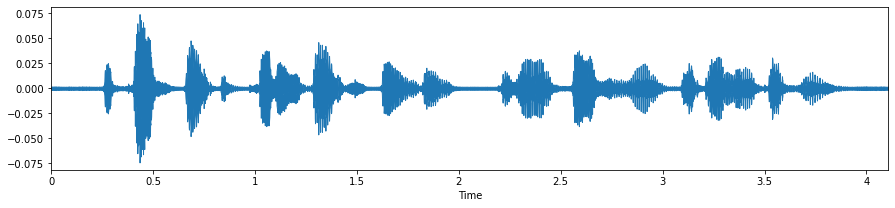

In [5]:
fname = SAVEE + 'KL_n27.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15,3))
librosa.display.waveplot(data, sr = sampling_rate)
#play the audio
ipd.Audio(fname)

it can be seen from waveplot speech is clear and there is no background noice or very less noise play with other sound tracks also and check background noise and speech clearity

# RAVDEES DATASET


* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

03-01-01-01-01-01-01.wav MEANS 03 audio only, 01 speech, 01 neutral, 01 normal intensity, 01 statement kids, 01 1st repeat and 01  means 1st actor

In [6]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []

for i in dir_list: 
    fname = os.listdir(RAV + i)
    for f in fname: 
        part = f.split(".")[0].split('-')
        emotion.append(int(part[2]))
        tmp = int(part[6])
        if tmp %2 == 0:
            tmp = 'female'
        else : 
            tmp = "male"
        gender.append(tmp)
        path.append(RAV + i + '/'+ f)
        

In [7]:
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1 : 'neutral',2 : 'neutral', 3 : 'happy', 4 : 'sad',5 : 'angry',6 : 'fear',7 : 'disgust',8 : 'surprise' })
RAV_df = pd.concat([pd.DataFrame(gender), RAV_df], axis = 1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] = RAV_df.gender + "_" + RAV_df.emotion
RAV_df = pd.concat([RAV_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
RAV_df.drop(['gender','emotion'], axis = 1)
RAV_df.labels.value_counts()

female_neutral     144
male_neutral       144
female_angry        96
male_happy          96
female_fear         96
female_disgust      96
male_disgust        96
female_sad          96
male_angry          96
male_sad            96
male_surprise       96
female_surprise     96
male_fear           96
female_happy        96
Name: labels, dtype: int64

# Data Exploration

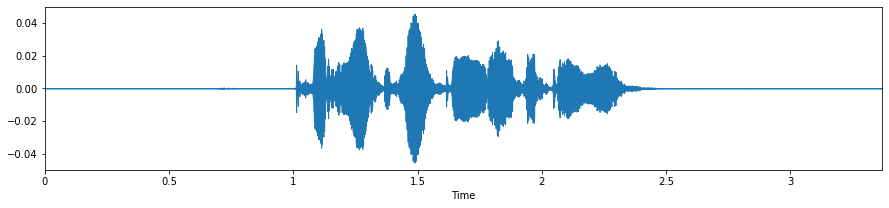

In [8]:
fname = RAV + 'Actor_04/03-01-01-01-01-02-04.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15,3))
librosa.display.waveplot(data, sr = sampling_rate)
#play the audio
ipd.Audio(fname)

As we can see from the waveform that, it is preety clear and less of background of noise and on the beginning and the end there is no speech so it is clear. 

# TESS DATASET


Now load the dataset

In [9]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

['OAF_Fear',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'OAF_angry',
 'OAF_disgust',
 'OAF_happy',
 'OAF_neutral',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

In [10]:
path = []
emotion = []
gender = []


for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname: 
        part = f.split(".")[0].split('_')
        tmp = part[0]
        if tmp == 'OAF':
            tmp = 'male'
        else : 
            tmp = 'female'
        gender.append(tmp)
        emotion.append(part[2])
        path.append(TESS + i + '/' + f)

TESS_df = pd.DataFrame(emotion)
TESS_df = pd.concat([pd.DataFrame(gender), TESS_df], axis = 1)
TESS_df.columns = ['gender','emotion']
TESS_df['labels'] = TESS_df.gender + "_" + TESS_df.emotion
TESS_df['source'] = TESS
TESS_df = pd.concat([TESS_df, pd.DataFrame(path,columns = ['path'])], axis = 1)
TESS_df = TESS_df.drop(['gender', 'emotion','source'], axis = 1)
TESS_df["labels"].replace({"male_ps": "male_surprise", "female_ps": "female_surprise"}, inplace=True)
TESS_df.labels.value_counts()
        
        
        

female_neutral     201
female_angry       200
male_happy         200
male_surprise      200
female_surprise    200
female_fear        200
female_disgust     200
male_disgust       200
female_sad         200
male_angry         200
male_sad           200
male_fear          200
female_happy       200
male_neutral       199
Name: labels, dtype: int64

# Data Exploration

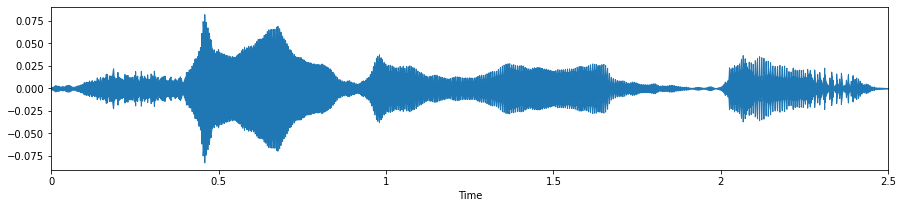

In [11]:
fname = TESS + '/OAF_Sad/OAF_bar_sad.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15,3))
librosa.display.waveplot(data, sr = sampling_rate)
#play the audio
ipd.Audio(fname)

# CREMA D Dataset

In [12]:
dir_list = os.listdir(CREMA)
dir_list.sort()
print(dir_list[0:10])

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


In [13]:
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)
    
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

male_happy        671
male_angry        671
male_sad          671
male_fear         671
male_disgust      671
female_angry      600
female_fear       600
female_disgust    600
female_sad        600
female_happy      600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

# Data Exploration

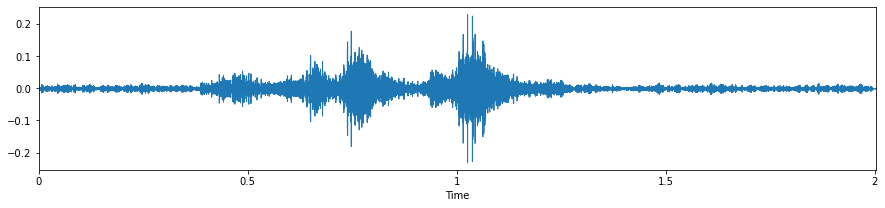

In [14]:
fname = CREMA + '/1001_DFA_SAD_XX.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15,3))
librosa.display.waveplot(data, sr = sampling_rate)
#play the audio
ipd.Audio(fname)

In [15]:
df = pd.concat([SAVEE_df, RAV_df, TESS_df, CREMA_df], axis = 0)
df.drop(['gender','emotion'], axis = 1)
print(df.labels.value_counts())
df.to_csv("Data_path1.csv",index=False)

male_neutral       1038
male_happy         1027
male_angry         1027
male_fear          1027
male_disgust       1027
male_sad           1027
female_disgust      896
female_happy        896
female_angry        896
female_fear         896
female_sad          896
female_neutral      857
male_surprise       356
female_surprise     296
Name: labels, dtype: int64


# Feature Extraction

There are two type of features 1. Time domain and 2nd is Frequency domain feature 

Time domain are simple to extract and understand, like energy of signal, zero crossing rate, maximum amplitude and minimum energy. Whereas frequency domain features are obtained by converting the time based signal into frequency domain and they are harder to comprehend and it provides the extra information like pitch , rhymes, meloduy etc. 

# MFCC

Mel frequency ceptral cofficient it is a good representation of vocal tract like X ray.  In machine learning applications MFCC are treated as the image representation of sound track and it can give more information and it has an ability to draw on transfer learning. 

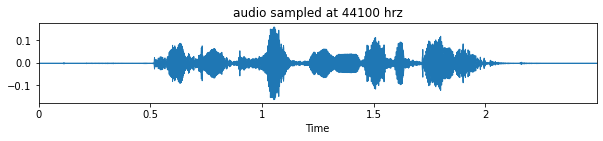

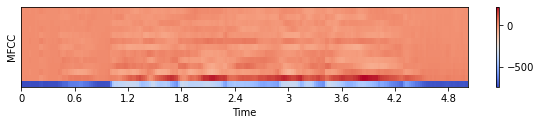

In [16]:
#checking out MFCC 
#source : RAVDESS, Gender  : Female and Emotion : Angry
path = "../input/ravdess-emotional-speech-audio/Actor_08/03-01-05-01-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type= 'kaiser_fast', duration = 2.5,sr = 22050*2, offset = 0.5)
mfcc = librosa.feature.mfcc(y = X, sr = sample_rate, n_mfcc = 13)

#audio wave graph

plt.figure(figsize = (10,5))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr = sample_rate)
plt.title('audio sampled at 44100 hrz')

#MFCC

plt.figure(figsize = (10,5))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis = 'time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

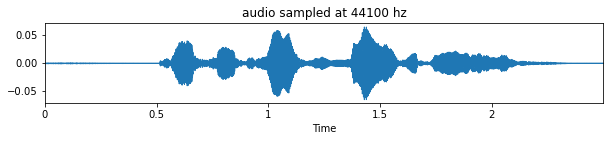

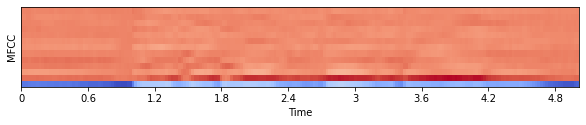

In [17]:
path = "../input/ravdess-emotional-speech-audio/Actor_06/03-01-03-01-01-01-06.wav"
X, sample_rate = librosa.load(path, res_type = 'kaiser_fast', duration = 2.5, sr = 22050*2, offset = 0.5)
mfcc = librosa.feature.mfcc(y = X, sr = sample_rate, n_mfcc = 13)

#audio waveform
plt.figure(figsize=(10,5))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr = sample_rate)
plt.title("audio sampled at 44100 hz")

#mfcc waveforms
plt.figure(figsize = (10,5))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis = 'time')
plt.ylabel('MFCC')

ipd.Audio(path)

# statistical features

here we are taking a mean across the each band over time and it will give us distinctive feature. if we see the MFCC plot, first band at the bottom is the most distinctive band and we are taking the shorter time window it means that, changes observed overtime does not vary greatly. So key feature is to capturing the information contained in the various bands and display it as a time series plot to illustrate the point.

216
216


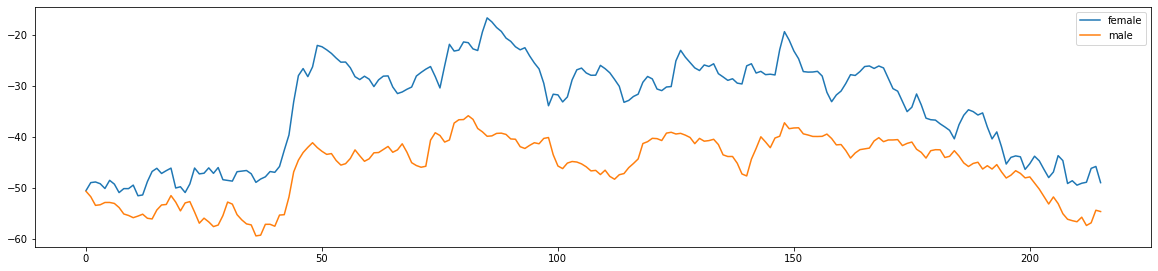

In [18]:
# comparing male and female angry for the same sentence uttered. 
path = "../input/ravdess-emotional-speech-audio/Actor_08/03-01-05-01-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type= 'kaiser_fast', duration = 2.5, sr = 22050*2, offset = 0.5)
female = librosa.feature.mfcc(y= X, sr = sample_rate, n_mfcc = 13)
female = np.mean(librosa.feature.mfcc(y = X, sr = sample_rate, n_mfcc = 13), axis = 0)
print(len(female))

# comparing male and female angry for the same sentence uttered. 
path = "../input/ravdess-emotional-speech-audio/Actor_06/03-01-03-01-01-01-06.wav"
X, sample_rate = librosa.load(path, res_type= 'kaiser_fast', duration = 2.5, sr = 22050*2, offset = 0.5)
male = librosa.feature.mfcc(y= X, sr = sample_rate, n_mfcc = 13)
male = np.mean(librosa.feature.mfcc(y = X, sr = sample_rate, n_mfcc = 13), axis = 0)
print(len(male))

#audio wave
plt.figure(figsize = (20,15))
plt.subplot(3,1,1)
plt.plot(female, label = 'female')

plt.plot(male, label = 'male')
plt.legend()

here we can see that for the same sentence spoken by male and female, female has higher pitch. 

## Model Creation 

Importing required libraries

In [19]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPool1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

#sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [20]:
ref = pd.read_csv('./Data_path1.csv')
ref.drop(['gender','emotion'], axis = 1, inplace = True)
ref.head()
print(ref.labels.value_counts())
ref.to_csv("Data_path2.csv",index=False)

male_neutral       1038
male_happy         1027
male_angry         1027
male_fear          1027
male_disgust       1027
male_sad           1027
female_disgust      896
female_happy        896
female_angry        896
female_fear         896
female_sad          896
female_neutral      857
male_surprise       356
female_surprise     296
Name: labels, dtype: int64


now we will read all the audio files , extract its mean across all MFCC bands by time and just keep extracting the features, dropping entire audio file data

In [21]:
ref1 = pd.read_csv('./Data_path2.csv')
ref1.head()

,labels,source,path
0,male_surprise,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
1,male_disgust,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
2,male_neutral,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
3,male_disgust,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
4,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...


In [22]:
df = pd.DataFrame(columns = ['features'])
# looping feature extraction over entire dataset

counter = 0
for index,path in enumerate(ref1.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast', duration = 2.5, sr = 22050*2, offset = 0.5)
    sample_rate = np.array(sample_rate)
    
    #taking mean of MFCC 
    mfccs = np.mean(librosa.feature.mfcc(y = X, sr = sampling_rate, n_mfcc = 13), axis = 0)
    df.loc[counter] = [mfccs]
    counter = counter+1 
print(len(df))
df.head()

12162


,features
0,"[-10.544089, -10.487962, -7.670357, -4.031042,..."
1,"[-34.291508, -23.095081, -17.720898, -16.19340..."
2,"[-20.014977, -19.500946, -22.183231, -24.65155..."
3,"[-22.95927, -22.394224, -23.359915, -23.79175,..."
4,"[-11.873209, -12.280961, -13.097414, -13.42713..."


In [23]:
df = pd.concat([ref1, pd.DataFrame(df['features']. values.tolist())], axis = 1)
df[:5]

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_surprise,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-10.544089,-10.487962,-7.670357,-4.031042,-1.465922,-2.007785,-4.514860,...,3.199854,3.760480,4.040915,3.799222,3.765629,3.508149,2.925530,2.365840,2.769154,2.832521
1,male_disgust,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-34.291508,-23.095081,-17.720898,-16.193407,-16.193083,-18.631178,-22.861971,...,-40.048256,-41.032738,-41.247776,-40.495083,-40.650913,-42.277771,-42.120308,-39.544250,-38.967911,-39.273380
2,male_neutral,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-20.014977,-19.500946,-22.183231,-24.651558,-27.089252,-28.584181,-32.415382,...,-22.926281,-21.888824,-21.065855,-20.311485,-19.339573,-18.269199,-17.932354,-19.151701,-22.485321,-25.849552
3,male_disgust,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-22.959270,-22.394224,-23.359915,-23.791750,-22.474871,-22.954752,-22.602804,...,-21.049282,-23.060225,-26.067085,-27.666700,-29.760160,-30.759062,-30.871452,-30.748600,-29.438988,-27.803535
4,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-11.873209,-12.280961,-13.097414,-13.427135,-14.647299,-16.274401,-16.555279,...,-41.525703,-43.018387,-42.715916,-42.798443,-41.745491,-41.366844,-42.158920,-41.838169,-40.720352,-40.388176


In [24]:
df = df.fillna(0)
print(df.shape)
df[:5]

(12162, 219)


,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_surprise,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-10.544089,-10.487962,-7.670357,-4.031042,-1.465922,-2.007785,-4.514860,...,3.199854,3.760480,4.040915,3.799222,3.765629,3.508149,2.925530,2.365840,2.769154,2.832521
1,male_disgust,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-34.291508,-23.095081,-17.720898,-16.193407,-16.193083,-18.631178,-22.861971,...,-40.048256,-41.032738,-41.247776,-40.495083,-40.650913,-42.277771,-42.120308,-39.544250,-38.967911,-39.273380
2,male_neutral,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-20.014977,-19.500946,-22.183231,-24.651558,-27.089252,-28.584181,-32.415382,...,-22.926281,-21.888824,-21.065855,-20.311485,-19.339573,-18.269199,-17.932354,-19.151701,-22.485321,-25.849552
3,male_disgust,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-22.959270,-22.394224,-23.359915,-23.791750,-22.474871,-22.954752,-22.602804,...,-21.049282,-23.060225,-26.067085,-27.666700,-29.760160,-30.759062,-30.871452,-30.748600,-29.438988,-27.803535
4,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,-11.873209,-12.280961,-13.097414,-13.427135,-14.647299,-16.274401,-16.555279,...,-41.525703,-43.018387,-42.715916,-42.798443,-41.745491,-41.366844,-42.158920,-41.838169,-40.720352,-40.388176


Splitting the data in 2 parts: training and validation and measuring models performance and accuracy 

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'], axis = 1), df.labels, test_size = 0.25, shuffle = True, random_state = 42)

In [26]:
X_train[150 : 160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
4950,-16.807531,-17.613955,-18.555740,-17.640551,-15.283868,-14.710440,-15.126077,-15.951246,-16.959272,-15.219698,...,-18.826042,-19.392080,-18.815144,-17.635557,-18.050743,-18.029787,-18.205179,-19.818512,-20.936775,-19.972023
3860,0.896325,-2.260751,-11.462572,-12.450342,-13.050553,-15.125727,-16.889872,-15.040421,-13.547408,-10.558272,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9761,1.809770,0.469233,-3.722257,-5.132461,-4.343592,-5.569754,-7.600326,-7.344791,-7.526195,-8.019352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7620,-2.781063,-3.044448,-3.121415,-2.916970,-3.027739,-2.345231,-3.273163,-3.814917,-4.218668,-3.957380,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11586,-23.063534,-22.369799,-20.683323,-18.868662,-11.878733,-7.991865,-8.005972,-7.631739,-8.159407,-8.980007,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7914,-18.290129,-18.360062,-16.146914,-15.345139,-17.731087,-18.732288,-19.014505,-17.972301,-16.725620,-18.182055,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9513,-16.378469,-16.340643,-15.489639,-15.100422,-15.577416,-15.870941,-17.360960,-17.232100,-16.564482,-14.310259,...,-15.990041,-17.934776,-17.271986,-19.492348,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5835,-17.421486,-16.529863,-14.773875,-14.654862,-13.767780,-13.405584,-12.779879,-13.184967,-13.301783,-13.267984,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5389,-21.396311,-19.506454,-18.127619,-18.370098,-19.521862,-19.200783,-18.933180,-20.272285,-20.140800,-19.232182,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11222,-18.298796,-17.505947,-18.743471,-17.663158,-17.525385,-16.512587,-18.280254,-19.138243,-17.983913,-16.135183,...,-18.478411,-18.941738,-19.391432,-19.251776,-18.134233,-16.684574,-16.332277,-17.460962,-17.398510,-17.706957


Now we will convert the data format to numpy array and implement a 1D CNN

In [27]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

#one hot encode target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)

#pickle lb object for future use

filename = 'labels'
outfile = open(filename, 'wb')
pickle.dump(lb,outfile)
outfile.close()

(9121, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


we are using 1D CNN, so we need to expand our dimention to 3rd dimention

In [28]:
X_train = np.expand_dims(X_train, axis = 2)
X_train.shape

(9121, 216, 1)

In [29]:
X_test = np.expand_dims(X_test, axis = 2)
X_test.shape

(3041, 216, 1)

# Creating Model

In [30]:
#New Model

model = Sequential()
model.add(Conv1D(256, 8, padding = 'same', input_shape = (X_train.shape[1],1))) 
model.add(Activation('relu'))
model.add(Conv1D(256,8,padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPool1D(pool_size = (8)))
model.add(Conv1D(128, 8 , padding = 'same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8 , padding = 'same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8 , padding = 'same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8 , padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPool1D(pool_size = (8)))
model.add(Conv1D(64, 8 , padding = 'same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8 , padding = 'same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # no of target class
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 256)          2304      
_________________________________________________________________
activation (Activation)      (None, 216, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 216, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 256)           0

In [31]:
opt = keras.optimizers.RMSprop(learning_rate = 0.00001, decay = 1e-6)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
history = model.fit(X_train,y_train, batch_size = 16, epochs = 100, validation_data = (X_test, y_test))

Epoch 1/100
571/571 [==============================] - 7s 11ms/step - loss: 2.5333 - accuracy: 0.1490 - val_loss: 2.4926 - val_accuracy: 0.2164
Epoch 2/100
571/571 [==============================] - 6s 10ms/step - loss: 2.3622 - accuracy: 0.2104 - val_loss: 2.3764 - val_accuracy: 0.2502
Epoch 3/100
571/571 [==============================] - 6s 10ms/step - loss: 2.2459 - accuracy: 0.2468 - val_loss: 2.2767 - val_accuracy: 0.2818
Epoch 4/100
571/571 [==============================] - 6s 10ms/step - loss: 2.1518 - accuracy: 0.2732 - val_loss: 2.2059 - val_accuracy: 0.2890
Epoch 5/100
571/571 [==============================] - 6s 10ms/step - loss: 2.0673 - accuracy: 0.2995 - val_loss: 2.1298 - val_accuracy: 0.3334
Epoch 6/100
571/571 [==============================] - 6s 10ms/step - loss: 2.0045 - accuracy: 0.3189 - val_loss: 2.0622 - val_accuracy: 0.3499
Epoch 7/100
571/571 [==============================] - 6s 11ms/step - loss: 1.9385 - accuracy: 0.3378 - val_loss: 2.0198 - val_accuracy:

571/571 [==============================] - 6s 10ms/step - loss: 1.2188 - accuracy: 0.5826 - val_loss: 1.5897 - val_accuracy: 0.4512
Epoch 58/100
571/571 [==============================] - 6s 10ms/step - loss: 1.2315 - accuracy: 0.5703 - val_loss: 1.5476 - val_accuracy: 0.4568
Epoch 59/100
571/571 [==============================] - 6s 10ms/step - loss: 1.2128 - accuracy: 0.5763 - val_loss: 1.6037 - val_accuracy: 0.4383
Epoch 60/100
571/571 [==============================] - 6s 11ms/step - loss: 1.2069 - accuracy: 0.5795 - val_loss: 1.5921 - val_accuracy: 0.4400
Epoch 61/100
571/571 [==============================] - 6s 11ms/step - loss: 1.2064 - accuracy: 0.5818 - val_loss: 1.5649 - val_accuracy: 0.4679
Epoch 62/100
571/571 [==============================] - 6s 10ms/step - loss: 1.1908 - accuracy: 0.5829 - val_loss: 1.5810 - val_accuracy: 0.4472
Epoch 63/100
571/571 [==============================] - 6s 10ms/step - loss: 1.1820 - accuracy: 0.5917 - val_loss: 1.5556 - val_accuracy: 0.460

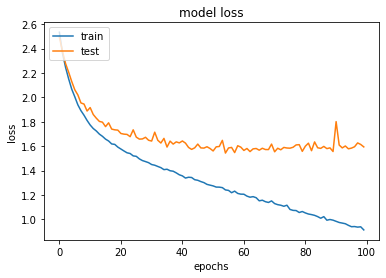

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel('epochs')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

# save the model

In [33]:
model_name = 'Emotion_recognition.h5'
save_dir = os.path.join(os.getcwd(),'saved_models')
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
model_path = os.path.join(save_dir,model_name)
model.save(model_path)
print("save model and weight at %s" %model_path)
#save model to disk
model_json = model.to_json()
with open("model_json.json", "w") as file:
    file.write(model_json)

save model and weight at /kaggle/working/saved_models/Emotion_recognition.h5


# Model Validation

In [34]:
#loading json and model architecture
json_file = open('../input/emotion-detection-weights-and-model/model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()


loaded_model = tf.keras.models.model_from_json(loaded_model_json)
#loaded_model = model_from_json(loaded_model_json)

#load weights into new model
loaded_model.load_weights("../input/emotion-detection-weights-and-model/Emotion_recognition.h5")
print("loaded model from disk")

#keras optimizer
opt = keras.optimizers.RMSprop(lr = 0.00001, decay = 1e-6)
loaded_model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose = 0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

loaded model from disk
accuracy: 53.70%


In [55]:
predictions = loaded_model.predict(X_test, batch_size = 16, verbose = 1)
predictions = predictions.argmax(axis = 1)
predictions = predictions.flatten()
predictions = lb.inverse_transform(predictions)
predictions = pd.DataFrame({'predictedvalues': predictions})

191/191 [==============================] - 0s 2ms/step


In [56]:
#actual label
actual = y_test.argmax(axis = 1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform(actual))
actual = pd.DataFrame({'actualvalues' : actual})                   

final_df = actual.join(predictions)
final_df[10: 40]

,actualvalues,predictedvalues
10,female_disgust,female_disgust
11,female_disgust,female_disgust
12,female_fear,female_fear
13,male_happy,male_happy
14,male_disgust,male_angry
15,male_happy,male_happy
16,male_angry,male_angry
17,female_happy,male_happy
18,male_disgust,male_disgust
19,female_neutral,female_neutral


In [58]:
final_df.to_csv('predictions.csv', index = False)
final_df.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,203
female_disgust,212
female_fear,304
female_happy,236
female_neutral,202
female_sad,273
female_surprise,72
male_angry,257
male_disgust,180


the confusion matrix heat map plot

In [59]:
def print_confusion_matrix(confusion_matrix,class_names, figsize = (10,7), fontsize = 14):
    #confusion_matrix is the numoy array, class_name is list
    
    df_cm = pd.DataFrame(confusion_matrix, index = class_names, columns = class_names)
    fig = plt.figure(figsize=figsize)
    
    try: 
        heatmap = sns.heatmap(df_cm, annot = True, fmt = 'd')
    except ValueError: 
        raise ValueError ('Confusion matrix must be integers')
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize= fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),rotation = 0, ha = 'right', fontsize= fontsize)
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
#gender record function

def gender(row):
    if  row =='female_angry' or "female_disgust" or "female_fear" or "female_happy" or "female_surprise" or "female_neutral" or "female_sad" :
        return 'female'
    elif row == 'male_angry' or "male_disgust" or "male_fear" or "male_happy" or "male_surprise" or "male_neutral" or "male_sad" :
        return 'male'

0.5369944097336402


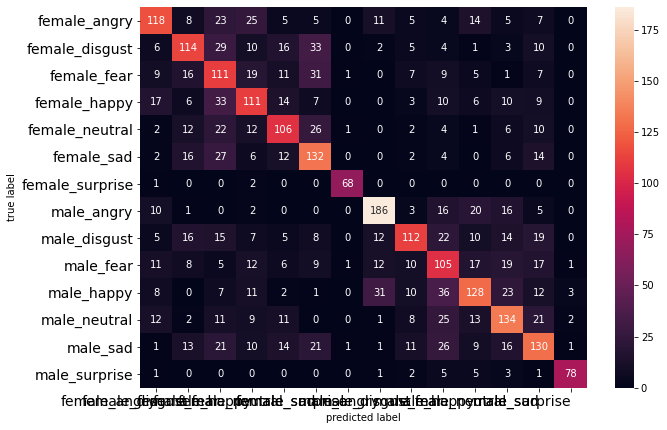

In [60]:
finaldf =pd.read_csv('predictions.csv')
classes = finaldf.actualvalues.unique()
classes.sort()


c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names=classes)

# classification report

In [61]:
classes = finaldf.actualvalues.unique()

classes.sort()

print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names = classes))

                 precision    recall  f1-score   support

   female_angry       0.58      0.51      0.55       230
 female_disgust       0.54      0.49      0.51       233
    female_fear       0.37      0.49      0.42       227
   female_happy       0.47      0.49      0.48       226
 female_neutral       0.52      0.52      0.52       204
     female_sad       0.48      0.60      0.53       221
female_surprise       0.94      0.96      0.95        71
     male_angry       0.72      0.72      0.72       259
   male_disgust       0.62      0.46      0.53       245
      male_fear       0.39      0.45      0.42       233
     male_happy       0.56      0.47      0.51       272
   male_neutral       0.52      0.54      0.53       249
       male_sad       0.50      0.47      0.48       275
  male_surprise       0.92      0.81      0.86        96

       accuracy                           0.54      3041
      macro avg       0.58      0.57      0.57      3041
   weighted avg       0.55   

# gender accuracy results

['female' 'male']
0.847418612298586


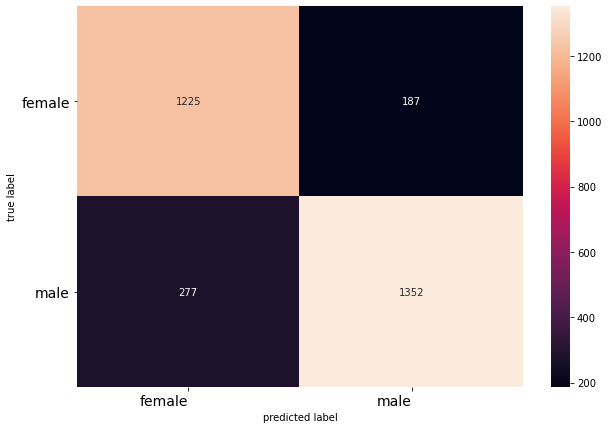

In [70]:
finaldf1 =pd.read_csv('predictions.csv')
modifieddf1 = finaldf1
modifieddf1['actualvalues'] = modifieddf1.actualvalues.replace({'female_angry' :'female','female_happy' :'female','female_sad' :'female','female_surprise' :'female', 'female_disgust' :'female','female_fear' :'female', 'female_neutral' :'female','male_angry' :'male','male_happy' :'male','male_sad' :'male','male_surprise' :'male', 'male_disgust' :'male','male_fear' :'male', 'male_neutral' :'male' })
modifieddf1['predictedvalues'] = modifieddf1.predictedvalues.replace({'female_angry' :'female','female_happy' :'female','female_sad' :'female','female_surprise' :'female', 'female_disgust' :'female','female_fear' :'female', 'female_neutral' :'female','male_angry' :'male','male_happy' :'male','male_sad' :'male','male_surprise' :'male', 'male_disgust' :'male','male_fear' :'male', 'male_neutral' :'male' })
classes = modifieddf1.actualvalues.unique()
classes.sort()
print(classes)
#confusion matrics

c = confusion_matrix(modifieddf1.actualvalues, modifieddf1.predictedvalues)
print(accuracy_score(modifieddf1.actualvalues, modifieddf1.predictedvalues))
print_confusion_matrix(c, class_names=classes)

In [72]:
classes = modifieddf1.actualvalues.unique()

classes.sort()

print(classification_report(modifieddf1.actualvalues, modifieddf1.predictedvalues, target_names = classes))

              precision    recall  f1-score   support

      female       0.82      0.87      0.84      1412
        male       0.88      0.83      0.85      1629

    accuracy                           0.85      3041
   macro avg       0.85      0.85      0.85      3041
weighted avg       0.85      0.85      0.85      3041



# emotion accuracy

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
0.578099309437685


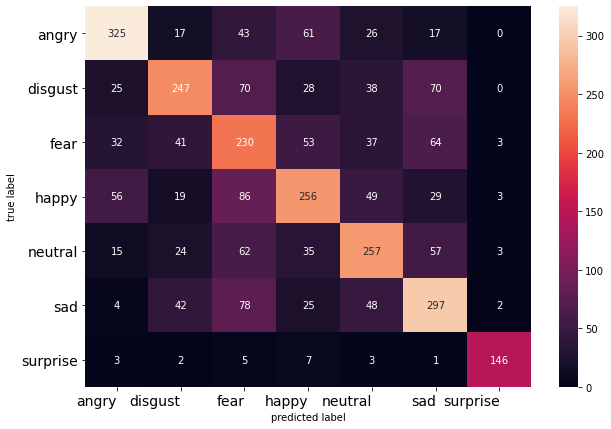

In [73]:
finaldf2 =pd.read_csv('predictions.csv')
modifieddf2 = finaldf2
modifieddf2['actualvalues'] = modifieddf2.actualvalues.replace({'female_angry' :'angry','female_happy' :'happy','female_sad' :'sad','female_surprise' :'surprise', 'female_disgust' :'disgust','female_fear' :'fear', 'female_neutral' :'neutral','male_angry' :'angry','male_happy' :'happy','male_sad' :'sad','male_surprise' :'surprise', 'male_disgust' :'disgust','male_fear' :'fear', 'male_neutral' :'neutral' })
modifieddf2['predictedvalues'] = modifieddf2.predictedvalues.replace({'female_angry' :'angry','female_happy' :'happy','female_sad' :'sad','female_surprise' :'surprise', 'female_disgust' :'disgust','female_fear' :'fear', 'female_neutral' :'neutral','male_angry' :'angry','male_happy' :'happy','male_sad' :'sad','male_surprise' :'surprise', 'male_disgust' :'disgust','male_fear' :'fear', 'male_neutral' :'neutral' })
classes = modifieddf2.actualvalues.unique()
classes.sort()
print(classes)
#confusion matrics

c = confusion_matrix(modifieddf2.actualvalues, modifieddf2.predictedvalues)
print(accuracy_score(modifieddf2.actualvalues, modifieddf2.predictedvalues))
print_confusion_matrix(c, class_names=classes)

In [ ]:
classes = modifieddf2.actualvalues.unique()

classes.sort()

print(classification_report(modifieddf2.actualvalues, modifieddf2.predictedvalues, target_names = classes))